In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import hog

## Preprocessing on images

#### 1. Reading all the images ( car and no-car images)

In [2]:
# Reading car images
vehicle_image_arr1 = glob.glob('/media/rd_square/Important/Image_processing/car_data_with_neg/vehicles/*/*.png')

# read images, flip images and append into list
vehicle_images_list = []
for imagePath in vehicle_image_arr1:
    readImage = cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    rgbImage = cv2.resize(rgbImage, (64,64))
    flippedImage = cv2.flip(rgbImage, flipCode=1) # flip horizontally
    vehicle_images_list.append(rgbImage)
    vehicle_images_list.append(flippedImage)
    
print("Reading of vehicle images done...")

# Reading non car images
no_vehicle_image_arr1 = glob.glob('/media/rd_square/Important/Image_processing/car_data_with_neg/non-vehicles/*/*.png')
no_vehicle_image_arr2 = glob.glob('/media/rd_square/Important/Image_processing/haar_cascade_classifier/neg/*.jpg')

# read images, flip images and append into list
no_vehicle_images_list = []
for imagePath in no_vehicle_image_arr1:
    readImage = cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    rgbImage = cv2.resize(rgbImage, (64,64))
    flippedImage = cv2.flip(rgbImage, flipCode=1) # flip horizontally
    no_vehicle_images_list.append(rgbImage)
    no_vehicle_images_list.append(flippedImage)
    
for imagePath in no_vehicle_image_arr2:
    readImage = cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    rgbImage = cv2.resize(rgbImage, (64,64))
    no_vehicle_images_list.append(rgbImage)
    
    
print("Reading of non vehicle images done...")

print("No of Vehicles images: ", len(vehicle_images_list))
print("No of non vehicle images: ", len(no_vehicle_images_list))

Reading of vehicle images done...
Reading of non vehicle images done...
No of Vehicles images:  1150
No of non vehicle images:  1038


Shape of vehicle images:  (64, 64, 3)
Shpae of non vehicle images:  (64, 64, 3)


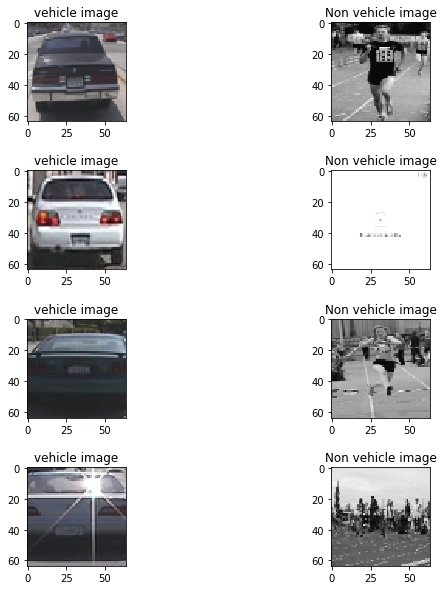

In [3]:
# Visualizing the vehicle and non vehicle images

f,axes = plt.subplots(4,2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

for index in range(4):
    vehicle= random.randint(0, len(vehicle_images_list)-1)
    non_vehicle=random.randint(0,len(no_vehicle_images_list)-1)
    axes[index,0].imshow(vehicle_images_list[vehicle])
    axes[index,1].imshow(no_vehicle_images_list[non_vehicle])
    axes[index,0].set_title('vehicle image')
    axes[index, 1].set_title('Non vehicle image')
    
print("Shape of vehicle images: ", str(vehicle_images_list[0].shape))
print("Shpae of non vehicle images: ", no_vehicle_images_list[0].shape)

## Extracting Features from images (HOG)

In [4]:
# Genral method to extract the HOG of theimage
def GetFeaturesFromHOG(image, orient, cellsPerBlock, pixelsPerCell,
                      visualise=False, feature_vector_flag=True):
    hog_features, hog_image = hog(image, orientations=orient,
                                 pixels_per_cell=(pixelsPerCell, pixelsPerCell),
                                 cells_per_block=(cellsPerBlock,cellsPerBlock),
                                 visualise=True, feature_vector=feature_vector_flag)
    return hog_features, hog_image

/home/rd_square/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Feature Vector Length Returned is  324
No of features that can be extracted from image  4096


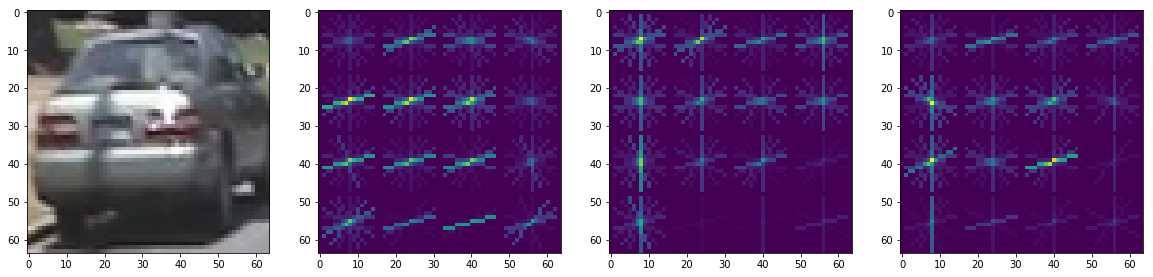

In [5]:
testingImage = vehicle_images_list[1]
image=cv2.cvtColor(testingImage, cv2.COLOR_RGB2YUV)
ch1 = image[:,:,0]
ch2 = image[:,:,1]
ch3 = image[:,:,2]

f0, i0 = GetFeaturesFromHOG(ch1, 9,2,16,visualise=True, feature_vector_flag=True)
f1, i1 = GetFeaturesFromHOG(ch2,  9,2,16,visualise=True, feature_vector_flag=True)
f2, i2 = GetFeaturesFromHOG(ch3,  9,2,16,visualise=True, feature_vector_flag=True)

f, axes = plt.subplots(1,4, figsize=(20,10))
axes[0].imshow(vehicle_images_list[1])
axes[1].imshow(i0)
axes[2].imshow(i1)
axes[3].imshow(i2)

print("Feature Vector Length Returned is ", len(f0))
print("No of features that can be extracted from image ", len(i0.ravel()))

## Generating Features Data for Machine Learning

In [6]:
# Method to extract the features based on HOG

def ExtractFeatures(images, orientation, cellsPerBlock, pixelsPerCell, convertColorSpace=True):
    featureList=[]
    imageList = []
    for image in images:
        if(convertColorSpace):
            image=cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        f1, img = GetFeaturesFromHOG(image[:,:,0], orientation, cellsPerBlock, pixelsPerCell, False, True)
        f2, img = GetFeaturesFromHOG(image[:,:,1],orientation, cellsPerBlock, pixelsPerCell, False, True)
        f3, img = GetFeaturesFromHOG(image[:,:,2], orientation, cellsPerBlock, pixelsPerCell, False, True)
        
        x = np.hstack((f1,f2,f3))
        featureList.append(x)
    return featureList

In [7]:
%%time

orientations=9
cellsPerBlock=2
pixelsPerCell=16
convertColorSpace=True
vehicleFeatures=ExtractFeatures(vehicle_images_list, orientations, cellsPerBlock, pixelsPerCell, convertColorSpace)
nonVehicleFeatures = ExtractFeatures(no_vehicle_images_list,orientations, cellsPerBlock, pixelsPerCell, convertColorSpace)

/home/rd_square/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


CPU times: user 1min 47s, sys: 184 ms, total: 1min 47s
Wall time: 1min 47s


In [8]:
featureList = np.vstack([vehicleFeatures, nonVehicleFeatures])
print("Shape of features list is " , featureList.shape)
labelList = np.concatenate([np.ones(len(vehicleFeatures)), np.zeros(len(nonVehicleFeatures))])
print("Shape of lable list is ", labelList.shape)

Shape of features list is  (2188, 972)
Shape of lable list is  (2188,)


## Data Preprocessing

In [9]:
# train test split of data
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(featureList, labelList, test_size=0.2, shuffle=True)

In [10]:
%%time

# Train a Linear SVM classifier
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(X_train, Y_train)
print("Classifier trained...")

Classifier trained...
CPU times: user 172 ms, sys: 32 ms, total: 204 ms
Wall time: 647 ms


In [11]:
print("Accuracy of SVC is ", classifier.score(X_test, Y_test))

Accuracy of SVC is  0.9863013698630136


## Visualising a car and detecting a car

In [95]:
# function to draw sliding windows

import matplotlib.image as mpimg

def draw_boxes(img, bboxes, color=(0,0,255), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    
    for bbox in bboxes:
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        color = (r,g,b)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [96]:
# function to find the windows on which we are going to run the classifier

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None,None],
                xy_window=(64,64), xy_overlap=(0.9,0.9)):
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    window_list = []
    image_width_x = x_start_stop[1] - x_start_stop[0]
    image_width_y = y_start_stop[1] - y_start_stop[0]
    
    windows_x = np.int(1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
    windows_y = np.int(1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))
    
    modified_window_size=  xy_window
    for i in range(0, windows_y):
        y_start = y_start_stop[0] + np.int(i * modified_window_size[1] * xy_overlap[1])
        for j in range(0, windows_x):
            x_start = x_start_stop[0] + np.int(j * modified_window_size[0] * xy_overlap[0])
            
            x1 = np.int(x_start+modified_window_size[0])
            y1 = np.int(y_start + modified_window_size[1])
            window_list.append(((x_start,y_start), (x1,y1)))
    return window_list

In [97]:
# function that returns the refined windows
# From Refined Windows we mean that the windows where the classifier predicts the output to be a car

def DrawCars(image, windows, convertColorspace= False):
    refinedWindows = []
    for window in windows:
        
        start = window[0]
        end = window[1]
        clippedImage = image[start[1]:end[1], start[0]:end[0]]   
        
        if (clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1] != 0):
            clippedImage = cv2.resize(clippedImage, (64,64))
            f1 = ExtractFeatures([clippedImage], 9,2,16,convertColorspace)
            
            predictedOutput = classifier.predict([f1[0]])
            if(predictedOutput==1):
                refinedWindows.append(window)
                
            plt.show()
    return refinedWindows

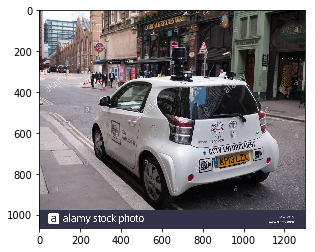

In [103]:
# testing out functions of slide_window and draw window. Defining here dummy windows

image = mpimg.imread('test.jpg')
plt.imshow(image)

In [101]:
windows1  = slide_window(image, x_start_stop=[0,200], y_start_stop=[0,200],
                        xy_window=(100,100), xy_overlap=(0.5,0.5))
windows = windows1  
print("Total No of windows are ", len(windows))


Total No of windows are  9


/home/rd_square/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


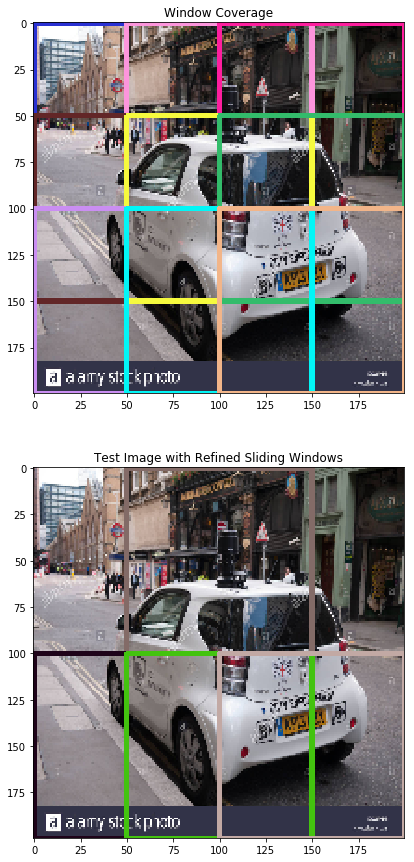

In [102]:
refinedWindows = DrawCars(image, windows, True)

f,axes = plt.subplots(2,1, figsize=(30,15))

window_img = draw_boxes(image, windows)

axes[0].imshow(window_img)
axes[0].set_title("Window Coverage")

window_img = draw_boxes(image, refinedWindows)

axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)

In [18]:
anotherImage = mpimg.imread('test3.jpg')

In [ ]:
# Search for car in image

def findCar(image, start_x = 0, start_y = 0, window_size=(64,64), convertColorspace=True):
    # list of all cars window searched
    carWindowList = []
    for row in range(400, 500,10):
        for col in range(800, 1000,10):
            print(row, col)
            clippedImage = image[row:row+window_size[0], col:col+window_size[0]]
            
            clippedImage = cv2.resize(clippedImage, (64, 64))
            
            f1= ExtractFeatures([clippedImage], 9, 2, 16, convertColorspace)
            
            predictedOutput = classifier.predict([f1[0]])
            if (predictedOutput==1):
                carWindowList.append([[col,row],[col+window_size[0], row+window_size[0]]])
    return carWindowList

In [73]:
# function to increase the pixel by on einside each box

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1,y1), (x2,y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # Return updated heatmap
    return heatmap

In [74]:
# applying a threshold value to the image to filter out low pixel cells

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

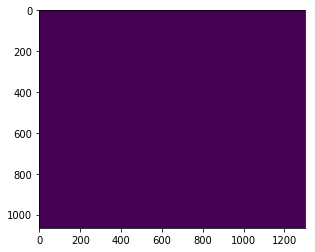

In [82]:
# testing our heat function

heat =np.zeros_like(image[:,:,0]).astype(np.float)
heat
plt.imshow(heat)

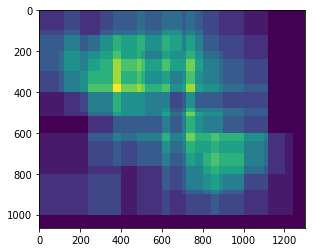

In [83]:
heat1 = add_heat(heat, refinedWindows)
plt.imshow(heat1)

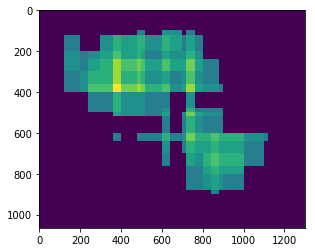

In [84]:
# Visualize the heatmap when displaying
heat2 = apply_threshold(heat1,5)
plt.imshow(heat2)

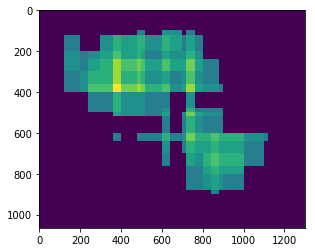

In [85]:
heatmap = np.clip(heat, 0, 255)
plt.imshow(heatmap)

In [86]:
from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox),np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
    return img

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 2)
Number of cars found -  2


Text(0.5,1,'Final image after applying heat map')

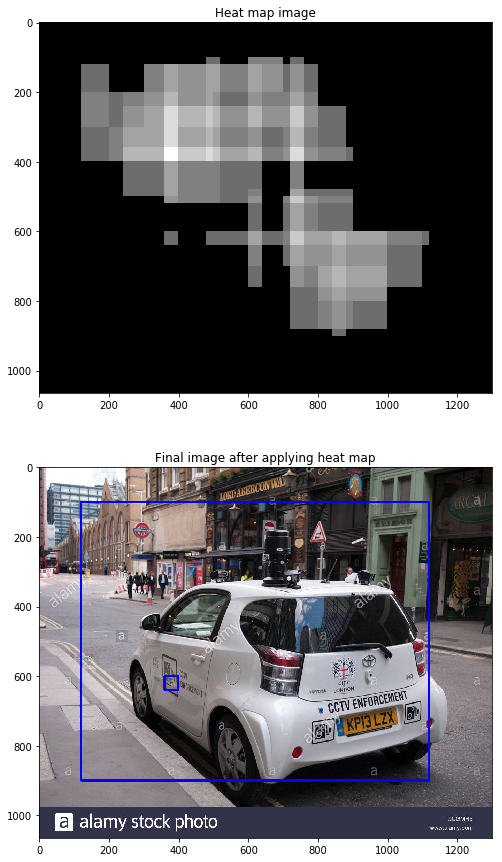

In [87]:
labels = label(heatmap)
print(labels)
print("Number of cars found - ", labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)

f,axes = plt.subplots(2,1,figsize=(30,15))
axes[0].imshow(heatmap, cmap='gray')
axes[0].set_title("Heat map image")
axes[1].imshow(draw_img)
axes[1].set_title("Final image after applying heat map")